# Differential Analysis

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/differential_analysis.ipynb)

In this tutorial, we will walk you through how to perform a differential analysis for identifying changes in the metabolic task scores between two conditions.

Here, we will use the results we previously generated for the Human Endometrial Cell Atlas (HECA) dataset [(Mareckova & Garcia-Alonso et al 2023)](https://doi.org/10.1038/s41588-024-01873-w) by running our [Quick Start Tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/quick_start_human.html).

## This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading endometrium results](#loading-endometrium-results)
* [Defining cell types](#defining-cell-types)
* [Data preparation](#data-preparation)
* [Differential analysis](#differential-analysis)
* [Results interpretation and visualization](#results-interpretation-and-visualization)
* [Additional differential analysis](#additional-differential-analysis)

## Loading libraries  <a class="anchor" id="loading-libraries"></a>

In [1]:
import sccellfie
import scanpy as sc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import textwrap

import os
import re

## To avoid warnings
import warnings
warnings.filterwarnings("ignore")

/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In addition, we set up a folder to save our figures. This folder is stored in the settings of Scanpy:

In [2]:
sc.settings.figdir = './results/da-figures/'

In [3]:
os.makedirs(sc.settings.figdir, exist_ok=True)

## Loading endometrium results <a class="anchor" id="loading-endometrium-results"></a>

We start opening the results previously generated by running the scCellFie pipeline on the HECA dataset. If you haven't run the pipeline yet, please follow [this tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/quick_start_human.html).

In this case, we will load the objects that were present in ``results['adata']`` in that tutorial. This object contains:
- ``results['adata']``: contains gene expression in ``.X``.
- ``results['adata'].layers['gene_scores']``: contains gene scores as in the original CellFie paper.
- ``results['adata'].uns['Rxn-Max-Genes']``: contains determinant genes for each reaction per cell.
- ``results['adata'].reactions``: contains reaction scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.
- ``results['adata'].metabolic_tasks``: contains metabolic task scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.

Here, we will name this object directly as ``adata``. Each of the previous elements should be under ``adata.``, as for example ``adata.metabolic_tasks``.

In [4]:
adata = sccellfie.io.load_adata(folder='./results/',
                                filename='Human_HECA_scCellFie'
                               )

./results//Human_HECA_scCellFie.h5ad was correctly loaded
./results//Human_HECA_scCellFie_reactions.h5ad was correctly loaded
./results//Human_HECA_scCellFie_metabolic_tasks.h5ad was correctly loaded


In this case, we are interested in the metabolic task scores, which can be found in the adata.metabolic_tasks AnnData object.

In [5]:
adata.metabolic_tasks

AnnData object with n_obs × n_vars = 90001 × 215
    obs: 'n_genes', 'sample', 'percent_mito', 'n_counts', 'Endometriosis_stage', 'Endometriosis', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Age', 'lineage', 'celltype', 'label_long'
    uns: 'Binary Stage_colors', 'Biopsy_type_colors', 'Endometrial_pathology_colors', 'Endometriosis_stage_colors', 'GarciaAlonso_celltype_colors', 'Group_colors', 'Hormonal treatment_colors', 'Library_genotype_colors', 'Mareckova_celltype_colors', 'Mareckova_epi_celltype_colors', 'Mareckova_lineage_colors', 'Processing_colors', 'Symbol_colors', 'Tan_cellsubtypes_colors', 'Tan_celltype_colors', 'Treatment_colors', 'celltype_colors', 'dataset_colors', 'genotype_colors', 'hvg', 'label_long_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'lineage_colors', 'neighbors', 'normalization', 'phase_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## Defining cell types <a class="anchor" id="defining-cell-types"></a>

For metabolic marker identification, we need to specify which column in the AnnData object contains the cell type information:

In [6]:
# Our column indicating the cell types in the adata.obs dataframe
# Here, label_long contains the full name of cell types.
# Shorter names can be found under the celltype column
cell_group = 'label_long'

Which can be visualized as

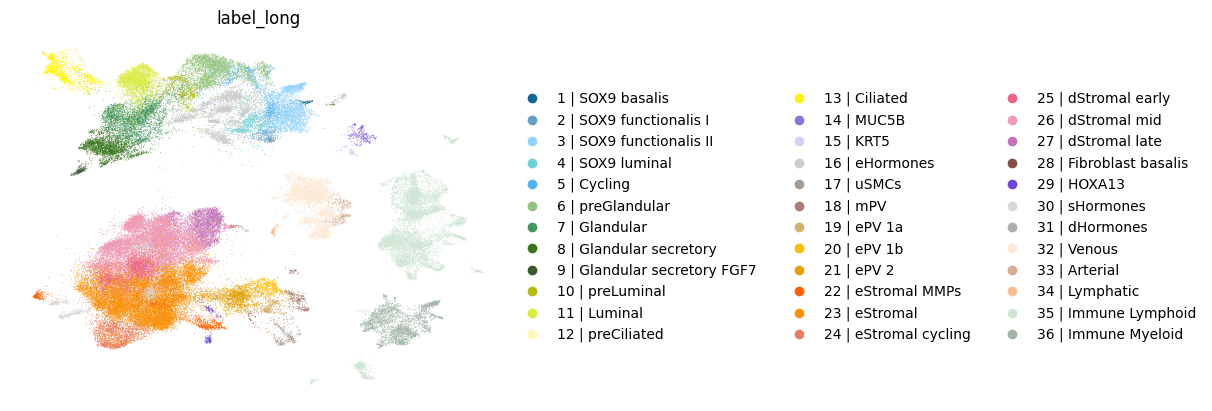

In [7]:
sc.pl.umap(adata, color=cell_group, frameon=False)

## Differential analysis <a class="anchor" id="differential-analysis"></a>

We can perform a differential analysis to identify changes between two conditions (per cell type). In this case, we focus on donors with and without endometriosis

### Select conditions to compare

In [8]:
adata.obs.Endometriosis.unique()

['Control', 'Endometriosis']
Categories (2, object): ['Control', 'Endometriosis']

In [9]:
contrasts = [('Control', 'Endometriosis')]
condition_key = 'Endometriosis'

### Filter testable cell types (optional)

Additionally, we can filter cell types to test. This may be useful to increase statistical power as in some cases, for a given cell type, one condition could have substantially more single cells than the other, affecting the results.

In this case we can filter by:
1. Number of minimum cells per cell type
2. Ratio of single cells between conditions

In [10]:
# Here, we pick celltype column for the counts, but this doesn't matter as all columns will have the same counts.
control_cells = adata.metabolic_tasks.obs.groupby(['Endometriosis', cell_group])['celltype'].count().loc['Control']
endo_cells = adata.metabolic_tasks.obs.groupby(['Endometriosis', cell_group])['celltype'].count().loc['Endometriosis']

In [11]:
# Filters
min_n = 50 # Here we do not use a big number as we are only using a subset of the original dataset.
max_log2ratio = 6 # This is 2 power 6 (or 64)

testable_cells = control_cells.index[(control_cells >= min_n) & (endo_cells >= min_n) & (np.log2(control_cells / endo_cells).abs() <= max_log2ratio)].tolist()

In [12]:
testable_cells

['3 | SOX9 functionalis II',
 '4 | SOX9 luminal',
 '5 | Cycling',
 '6 | preGlandular',
 '7 | Glandular',
 '8 | Glandular secretory',
 '10 | preLuminal',
 '11 | Luminal',
 '12 | preCiliated',
 '13 | Ciliated',
 '14 | MUC5B',
 '16 | eHormones',
 '20 | ePV 1b',
 '21 | ePV 2',
 '22 | eStromal MMPs',
 '23 | eStromal',
 '24 | eStromal cycling',
 '25 | dStromal early',
 '26 | dStromal mid',
 '27 | dStromal late',
 '29 | HOXA13',
 '30 | sHormones',
 '32 | Venous',
 '33 | Arterial',
 '35 | Immune Lymphoid',
 '36 | Immune Myeloid']

In case you do not want to filter testable cells, just leave ``input_adata = adata.metabolic_tasks``.

We can also test individual reactions instead of metabolic tasks; in that case, use ``adata.reactions``.

In [13]:
input_adata = adata.metabolic_tasks[adata.metabolic_tasks.obs['label_long'].isin(testable_cells)]

### Perform differential analysis

scCellFie implements a Wilcoxon rank sum test (a.k.a. Mann-Whitney U test) by using the Scanpy's implementation. However, other differential analyses could be performed by using external tools. For example, [Pertpy offers multiple options](https://pertpy.readthedocs.io/en/stable/tutorials/notebooks/differential_gene_expression.html). Advanced users can implement their own [GLMs by using statsmodels](https://www.statsmodels.org/stable/glm.html).

In [ ]:
de_results = sccellfie.stats.scanpy_differential_analysis(input_adata,
                                                          cell_type=None, 
                                                          cell_type_key=cell_group, 
                                                          condition_key=condition_key,
                                                          min_cells=0, # We do not use this as we already filtered cells before
                                                          condition_pairs=contrasts)

Processing DE analysis:  77%|███████▋  | 20/26 [00:56<00:18,  3.10s/it]

## Results interpretation and visualization <a class="anchor" id="results-interpretation-and-visualization"></a>

Once we have our results, the first thing we can do it's to export them:

In [ ]:
de_results.reset_index().to_csv(f'{sc.settings.figdir}/DE-Endometriosis.csv')

When inspecting our results, we find multiple columns containing useful information:

- ``cell_type``: The annotated cell type in which the differential analysis was performed, in this case corresponds to the column ``'long_label'`` in the ``input_adata.obs`` dataframe.
- ``feature``: The metabolic task evaluated for differential activity. This could be reactions or genes depending on the AnnData object used as input.
- ``group1`` and ``group2``: The two biological conditions or groups being compared. 
- ``log2FC``: The log2 fold-change in metabolic activity between group2 and group1, where positive values indicate higher activity in group2. Here the mean activity in each group-cell type is used.
- ``test_statistic``: The value of the test statistic used for assessing significance (e.g., from a Wilcoxon or t-test).
- ``p_value``: The unadjusted p-value indicating the likelihood of observing this result by chance.
- ``cohens_d``: The effect size (Cohen's D), which quantifies the difference between two means (from each group) divided by a standard deviation for the data. Positive values indicate higher mean in group2, while negative values indicate higher mean in group1.
- ``n_group1`` and ``n_group2``: The number of cells in group1 and group2, respectively, used in the comparison.
- ``median_group1`` and ``median_group2``: The median inferred metabolic activity for the feature in group1 and group2, respectively.
- ``median_diff``: The difference in median values between group2 and group1.
- ``adj_p_value``: The p-value adjusted for multiple testing, typically using the Benjamini-Hochberg FDR correction.

In [ ]:
de_results.head()

### Visualizations

We can use a beeswarm plot, where each row (y-axis) represents the cell types, and the x-axis shows the effect size. Dots are each of the tested features (metabolic tasks), and colored whether they pass both filters, adj. P value and effect size (Cohen's D here).

To understand this plot, each row can be seen as a "flattened volcano plot".


We first set some filter to call a result significant:

In [ ]:
cohen_threshold = 0.75 # Min value of absolute Cohen's D.
pval_threshold = 0.01 # Min adj. P value
logfc_threshold = np.log2(1.1) # Min log2FC. Leave it as np.log2(1.) if you do not want to use this filter

We can pass a function to sort cells in the y-axis. This function is to sort them by they cluster number:

In [ ]:
sort_lambda = lambda x: pd.Series([int(s.split(' | ')[0]) for s in x])

In [ ]:
fig, ax, sig = sccellfie.plotting.create_beeswarm_plot(de_results,
                                                       x='cohens_d', 
                                                       cohen_threshold=cohen_threshold, 
                                                       pval_threshold=pval_threshold,
                                                       logfc_threshold=logfc_threshold,
                                                       show_n_significant=True, # To indicate the number of significant features at the right of the plot
                                                       strip_jitter=True,
                                                       sort_lambda=sort_lambda,
                                                       lgd_bbox_to_anchor=(0.5, -0.1), # Location of the legend
                                                       ticks_fontsize=16,
                                                       labels_fontsize=18,
                                                       figsize=(12, 10), )

# Remove cluster number (optional)
ylabels = ax.get_yticklabels()
ax.set_yticklabels([t.get_text().split(' | ')[1] for t in ylabels])
ax.set_ylabel('')

plt.savefig(f'{sc.settings.figdir}/Endometriosis-DE.pdf', dpi=300, bbox_inches='tight')

The number of unique metabolic tasks changing across all cell types:

In [ ]:
sig_tasks = sig.reset_index().feature.unique().tolist()
len(sig_tasks)

Alternatively, we can use a volcano plot for one cell type at a time.

In [ ]:
luminal_tasks = sccellfie.plotting.create_volcano_plot(de_results, 
                                                       effect_threshold=0.75,
                                                       padj_threshold=0.05, 
                                                       cell_type='11 | Luminal',
                                                       group1=None,
                                                       group2=None,
                                                       effect_col='cohens_d', 
                                                       effect_title="Cohen's d", 
                                                       wrapped_title_length=50,
                                                       save='Overall-VolcanoPlot', 
                                                       dpi=300, 
                                                       tight_layout=True
                                                      )

In [ ]:
len(luminal_tasks)

### Plot number of major task groups up/down regulated

We use our outputs from scCellFie to calculate the number of significant tasks given their major categories located in `sccellfie_db['task_info']`, after downloading the scCellFie's database:

In [ ]:
sccellfie_db = sccellfie.datasets.load_sccellfie_database(organism='human')

We define our function to make a plot showing these numbers

In [ ]:
def plot_single(condition, ax, pathway, sig_data):
    pathway_counts = {'System': pd.DataFrame(), 'Subsystem': pd.DataFrame()}

    for c, df in sig_data.reset_index().groupby('cell_type'):
        for k, v in pathway_counts.items():
            df2 = df.set_index('feature').join(sccellfie_db['task_info'].set_index('Task'), how='inner')
            df2 = df2.loc[df2.log2FC > 0] if condition == 'up' else df2.loc[df2.log2FC < 0]
            df2 = df2.value_counts(k).to_frame().reset_index()
            df2['cell_type'] = c
            df2 = df2[['cell_type', k, 'count']]
            df2[k] = df2[k].apply(lambda x: x.upper())
            pathway_counts[k] = pd.concat([pathway_counts[k], df2])

    df = pathway_counts[pathway].sort_values('count')
    totals = df.groupby('cell_type')['count'].sum()

    df_normalized = df.copy()
    df_normalized['fraction'] = df.groupby('cell_type')['count'].transform(lambda x: x / x.sum())
    pivoted_data = df_normalized.pivot(index='cell_type', columns=pathway, values='fraction')
    pivoted_data = pivoted_data.sort_index().fillna(0.)

    n_systems = len(pivoted_data.columns)
    colors = glasbey.extend_palette('Set2', palette_size=max([n_systems, 10]))

    pivoted_data.plot(kind='barh', stacked=True, ax=ax, color=colors, legend=False)
    ax.set_xlim((0, 1))
    ax.invert_yaxis()

    ylabels = ax.get_yticklabels()
    ax.tick_params(axis='both', which='major', labelsize=12)

    for idx, cell_type in enumerate(pivoted_data.index):
        ax.text(1.02, idx, f'n={totals[cell_type]:,}', va='center', fontsize=12)

    ax.set_xlabel('Fraction', fontsize=14)
    ax.set_ylabel('')

    return pivoted_data.columns, colors

Then we plot these numbers

In [ ]:
from matplotlib.colors import to_rgb

pathway = 'System'
condition1_color='#8B0000'
condition2_color='#000080'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12), height_ratios=[1, 1])

legend_elements, colors = plot_single('up', ax1, pathway, sig)
plot_single('down', ax2, pathway, sig)

ax1.set_title('Endometriosis', fontsize=16, pad=10, color=to_rgb(condition2_color))
ax2.set_title('Control', fontsize=16, pad=10, color=to_rgb(condition1_color))

plt.figlegend(labels=legend_elements, 
              bbox_to_anchor=(0.5, -0.005),
              ncols=2 if pathway == 'System' else 2,
              frameon=False,
              loc='upper center')

plt.subplots_adjust(hspace=0.5)
# For saving this figure, uncomment the code below
# plt.savefig(f'{sc.settings.figdir}./scCellFie-DA-{pathway}-Combined.pdf', 
#             dpi=300, 
#             bbox_inches='tight')

### Visualize changes in distributions across single cells

For the significant tasks, we can also compare their distribution of metabolic scores for each condition.

In [ ]:
cell_show = ['7 | Glandular', '11 | Luminal',]

for c in cell_show:
    sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index]
    N = len(sig_features)
    if N > 0:
        width = min([18, 1.5 + 0.5*N])
        fig, ax = sccellfie.plotting.create_comparative_violin(adata=adata.metabolic_tasks, 
                                                               significant_features=sig_features,
                                                               group1='Control', 
                                                               group2='Endometriosis',
                                                               condition_key=condition_key, 
                                                               cell_type_key=cell_group,
                                                               celltype=c,
                                                               xlabel='',
                                                               ylabel='Metabolic Score',
                                                               palette=['coral','cornflowerblue'],
                                                               wrapped_title_length=100,
                                                               figsize=(width, 4),
                                                               fontsize=14,
                                                               title=c,
                                                               tight_layout=False,
                                                               #save=f'DE-Dist-{cname}'
                                                              )


## Additional differential analysis <a class="anchor" id="additional-differential-analysis"></a>

Another analysis in scCellFie is a differential analysis comparing each metabolic task between conditions, using all single cells. In contrast, the analysis shown in the previous sections performs it in a cell-type-wise manner. Here, we also use a Wilcoxon rank sum test.

In [ ]:
da_all = sccellfie.stats.pairwise_differential_analysis(adata.metabolic_tasks,
                                                        groupby='Endometriosis', # Column including the conditions
                                                        var_names=None,
                                                        order=None,
                                                        alternative='two-sided',
                                                        alpha=0.05)

The columns here are consistent with the previous analysis, but the ``cell_type`` column is not included:


- ``feature``: The metabolic task evaluated for differential activity. This could be reactions or genes depending on the AnnData object used as input.
- ``group1`` and ``group2``: The two biological conditions or groups being compared. 
- ``log2FC``: The log2 fold-change in metabolic activity between group2 and group1, where positive values indicate higher activity in group2. Here the mean activity in each group-cell type is used.
- ``test_statistic``: The value of the test statistic used for assessing significance (e.g., from a Wilcoxon or t-test).
- ``p_value``: The unadjusted p-value indicating the likelihood of observing this result by chance.
- ``cohens_d``: The effect size (Cohen's D), which quantifies the difference between two means (from each group) divided by a standard deviation for the data. Positive values indicate higher mean in group2, while negative values indicate higher mean in group1.
- ``n_group1`` and ``n_group2``: The number of cells in group1 and group2, respectively, used in the comparison.
- ``median_group1`` and ``median_group2``: The median inferred metabolic activity for the feature in group1 and group2, respectively.
- ``median_diff``: The difference in median values between group2 and group1.
- ``adj_p_value``: The p-value adjusted for multiple testing, typically using the Benjamini-Hochberg FDR correction.

In [ ]:
da_all.head()

### Volcano plot

In [ ]:
overall_tasks = sccellfie.plotting.create_volcano_plot(da_all, 
                                                       effect_threshold=0.25,
                                                       padj_threshold=0.05, 
                                                       cell_type=None,
                                                       group1=None,
                                                       group2=None,
                                                       effect_col='cohens_d', 
                                                       effect_title="Cohen's d", 
                                                       wrapped_title_length=50,
                                                       save='Overall-VolcanoPlot', 
                                                       dpi=300, 
                                                       tight_layout=True
                                                      )

In [ ]:
len(overall_tasks)

In [ ]:
overall_tasks